In [88]:
import pandas as pd
import numpy as np
import random
from functools import partial

%matplotlib inline
from matplotlib import pyplot

## Experiment 1: static vote counting

In [3]:
def count_votes(sampling_dist,nb_iter,condition):
    def check_quality(idx_ans):
        if condition.iloc[idx_ans]>random.random() :
            return idx_ans + 1
        return 0
                
    counts_cond = pd.concat([sampling_dist]*nb_iter,axis=1).apply(
                        lambda col: check_quality(col[col>random.random()].index[0]))
    return counts_cond[counts_cond>0].values

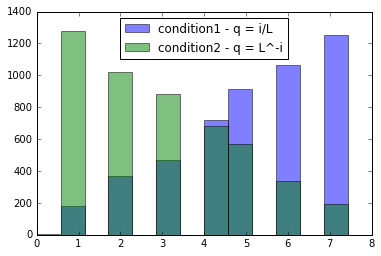

In [7]:

nb_iter = 10000
nb_ans = 8
pbias = pd.Series([1 - i/nb_ans for i in range(1,nb_ans+1)])
pbias = (pbias/pbias.sum()).cumsum()
count_experiment = partial(count_votes,pbias,nb_iter)

q1 = pd.Series([float(i)/nb_ans for i in range(1,nb_ans+1)])
q2 = pd.Series([1 - float(i)/nb_ans for i in range(1,nb_ans+1)])
#q2 = pd.Series([(nb_ans**-i) for i in range(1,nb_ans+1)])


bins = np.linspace(0, nb_ans, int((nb_ans-1)/0.5)+1)        
pyplot.hist(count_experiment(q1), bins, alpha=0.5,label='condition1 - q = i/L')
pyplot.hist(count_experiment(q2), bins, alpha=0.5,label='condition2 - q = L^-i')
pyplot.legend(loc='best')
pyplot.show()

## Experiment 2: do answers find a stable position?

In [69]:
from scipy.stats import beta

In [70]:
def voting_pq(pbias,tgt_order,init_q):
    q_votes = pd.concat([init_q['q'],init_q['ans'],pd.Series(np.zeros(init_q.shape[0]),name='votes')],axis=1)
    while True:
        sample_idx = pbias[pbias>random.random()].index[0]
        if q_votes['q'].iloc[sample_idx]>random.random():
            q_votes.loc[q_votes.index==sample_idx,'votes'] = q_votes.loc[q_votes.index==sample_idx,'votes'] + 1
            q_votes = q_votes.sort_values(by=['votes'],ascending=False)
            q_votes.index = range(q_votes.shape[0])
            yield np.absolute(q_votes['ans'].values-tgt_order).sum()

In [71]:
def voting_p(pbias,tgt_order,init_q):
    q_votes = pd.concat([init_q['q'],init_q['ans'],pd.Series(np.zeros(init_q.shape[0]),name='votes')],axis=1)
    while True:
        sample_idx = pbias[pbias>random.random()].index[0]
        q_votes.loc[q_votes.index==sample_idx,'votes'] = q_votes.loc[q_votes.index==sample_idx,'votes'] + 1
        q_votes = q_votes.sort_values(by=['votes'],ascending=False)
        q_votes.index = range(q_votes.shape[0])
        yield np.absolute(q_votes['ans'].values-tgt_order).sum()

In [72]:
def voting_q(pbias,tgt_order,init_q):
    q_votes = pd.concat([init_q['q'],init_q['ans'],pd.Series(np.zeros(init_q.shape[0]),name='votes')],axis=1)
    while True:
        sample_idx = random.choice(q_votes.index)
        if q_votes['q'].iloc[sample_idx]>random.random():
            q_votes.loc[q_votes.index==sample_idx,'votes'] = q_votes.loc[q_votes.index==sample_idx,'votes'] + 1
            q_votes = q_votes.sort_values(by=['votes'],ascending=False)
            q_votes.index = range(q_votes.shape[0])
            yield np.absolute(q_votes['ans'].values-tgt_order).sum()

In [73]:
def voting_cascade(pbias,tgt_order,init_q):
    q_votes = pd.concat([init_q['q'],init_q['ans'],pd.Series(np.zeros(init_q.shape[0]),name='votes')],axis=1)
    while True:
        q_votes.loc[:,'prev_q_prod'] = np.log(1-q_votes['q'])
        q_votes.loc[:,'prev_q_prod'] = np.exp(q_votes['prev_q_prod'].cumsum()
                                            -np.log(1-q_votes['q'])
                                            +np.log(q_votes['q']))
        q_votes.loc[:,'prev_q_prod'] = (q_votes['prev_q_prod']/q_votes['prev_q_prod'].sum()).cumsum()
        sample_idx = q_votes['prev_q_prod'][q_votes['prev_q_prod']>random.random()].index[0]
        q_votes.loc[q_votes.index==sample_idx,'votes'] = q_votes.loc[q_votes.index==sample_idx,'votes'] + 1
        q_votes = q_votes.sort_values(by=['votes'],ascending=False)
        q_votes.index = range(q_votes.shape[0])
        yield np.absolute(q_votes['ans'].values-tgt_order).sum()

In [ ]:
from itertools import takewhile,izip

def run_exp(nb_ans=8,max_votes=100):
    q_ans = pd.DataFrame({'ans':range(1,nb_ans+1),'q': np.random.uniform(0,1.0,nb_ans)})
    ans_sorted = q_ans.sort_values(by='q',ascending=False)['ans'].values
    pbias = pd.Series([1-(float(i)-1)/nb_ans for i in range(1,nb_ans+1)])
    pbias = (pbias/pbias.sum()).cumsum()
      
    pbias_voting = partial(voting_p,pbias,ans_sorted)
    q_voting = partial(voting_q,pbias,ans_sorted)
    pq_voting = partial(voting_pq,pbias,ans_sorted)
    cascade_voting = partial(voting_cascade,pbias,ans_sorted)
    
    distances = [(p,q,pq,casc) for i,(p,q,pq,casc) in takewhile(lambda t:t[0]<max_votes, enumerate(izip(pbias_voting(q_ans),
                                                                        q_voting(q_ans),
                                                                        pq_voting(q_ans),
                                                                        cascade_voting(q_ans))))]
    return zip(*distances)
    

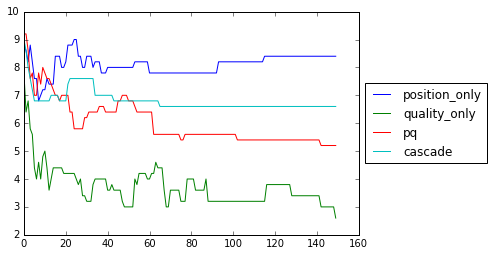

In [110]:

nb_ans = 5
nb_exp = 20
nb_votes = 150
pbias_dist, quality_dist, pbias_quality_dist, cascade_dist = [np.zeros(nb_votes)]*4

for _ in range(nb_exp):
    p,q,pq,csc = run_exp(nb_ans=nb_ans,max_votes=nb_votes)
    pbias_dist,quality_dist,pbias_quality_dist,cascade_dist = p+pbias_dist,q+quality_dist,pq+pbias_quality_dist,csc+cascade_dist
pbias_dist,quality_dist = pbias_dist/float(nb_exp),quality_dist/float(nb_exp)
pbias_quality_dist,cascade_dist = pbias_quality_dist/float(nb_exp),cascade_dist/float(nb_exp)



fig = pyplot.figure(1)
ax = fig.add_subplot(111)

votes_ax = range(nb_votes)
ax.plot(votes_ax,pbias_dist,label='position_only')
ax.plot(votes_ax,quality_dist,label='quality_only')
ax.plot(votes_ax,pbias_quality_dist,label='pq')
ax.plot(votes_ax,cascade_dist,label='cascade')
lgd = ax.legend(bbox_to_anchor=(1, 0.5), loc='center left')
pyplot.show()